In [45]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [46]:
# Global Variables

N = 256 # Image Size
G = 32 # Watermark Size
P = 38 # Max Moment

# Steps

T_STEP = int(P / 5) + 1
I_STEP = int(N / 10) + 1

In [47]:
%run -i ./ownlib/PHT-Library.ipynb
%run -i ./ownlib/RIW-Library.ipynb
%run -i ./ownlib/Utility.ipynb
%run -i ./ownlib/Inverse-Geometric.ipynb

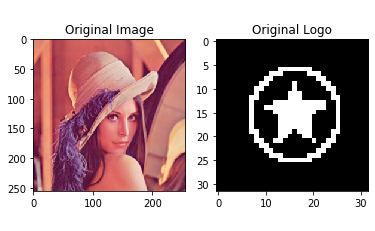

In [48]:
# Import images
ori_img = cv2.imread('./assets/lena.png') #BGR
ori_logo = cv2.imread('./assets/converse.png', 0)

# Preprocess Image
IMG_BGR = cv2.resize(ori_img, (N, N)) # Original Image
IMG_Y = getYFromBGR(IMG_BGR) #

# Preprocess Logo
LOGO = cv2.resize(ori_logo, (G,G))
LOGO = (LOGO >= 128) * 1

# Show Image and Logo
imgshow([[IMG_BGR, LOGO]], [['Original Image', 'Original Logo']])

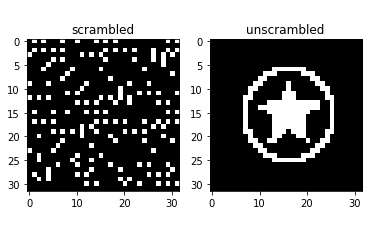

In [49]:
logo_sc = scramble(LOGO)
logo_usc = unscramble(logo_sc)
imgshow([[logo_sc, logo_usc]], [['scrambled', 'unscrambled']])

Progress: [####################] 100.0%


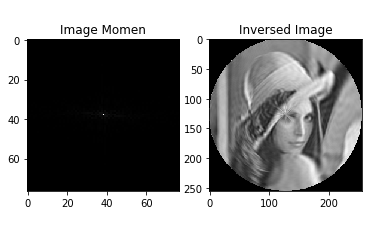

In [50]:
# Calculate Momen of Original Image
MOMEN = transformPHT(IMG_Y, N, P)
IMG_Y_INV = inversePHT(MOMEN, N, P)
imgshow([[MOMEN, IMG_Y_INV]], [['Image Momen', 'Inversed Image']])

Progress: [####################] 100.0%
2146


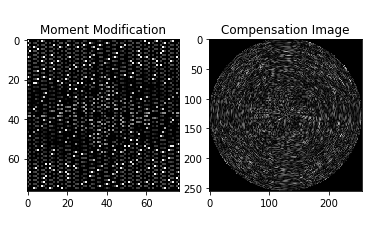

In [57]:
# Calculate Embedded Momen

# Watermarking Power
DELTA = 0.5

# Current Binary Value
matQ = np.floor(np.abs(MOMEN) / DELTA) % 2

# Set Watermark Position
P2 = P * 2 + 1

# Calculate Watermark Matrix
(doubleLogo, doubleFilter, maxIndex) = watermarkEmbed(LOGO, P)
        
# Modified Momen
XI = np.abs(MOMEN) - np.floor(np.abs(MOMEN) / DELTA) * DELTA

OMEGA = - XI
OMEGA = OMEGA + DELTA / 2 * (matQ == doubleLogo)
OMEGA = OMEGA + 3 * DELTA / 2 * np.logical_and(matQ != doubleLogo, np.logical_or(XI > DELTA / 2, np.abs(MOMEN) < DELTA))
OMEGA = OMEGA - DELTA / 2 * np.logical_and(matQ != doubleLogo, np.logical_and(XI <= DELTA / 2, np.abs(MOMEN) >= DELTA))

OMEGA = OMEGA / (np.abs(MOMEN) + 0.000000001) * MOMEN
OMEGA = OMEGA * doubleFilter

# Calculate Compensation Image
EPSILON = inversePHT(OMEGA, N, P)
# EPSILON = OMEGA

# Show Modified Momen
imgshow([[OMEGA, EPSILON]], [['Moment Modification', 'Compensation Image']])
print(maxIndex)

In [58]:
print(np.max(OMEGA))
print(np.min(OMEGA))

(0.7313327956713754+0.03252398827130284j)
(-0.7258906056802685-0.06040032800820742j)


In [59]:
print(np.max(EPSILON))
print(np.min(EPSILON))

(64.96984895073223-2.581268532253489e-15j)
(-57.987852001442945-1.915134717478395e-15j)


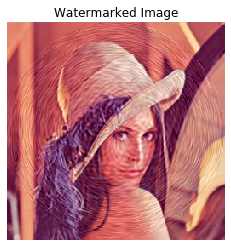

In [60]:
# Add Compensation Image to Original Image
# IMG_Y_WATERMARKED = IMG_Y + (EPSILON - np.min(IMG_Y_INV)) / (np.max(IMG_Y_INV) - np.min(IMG_Y_INV)) * 255
IMG_Y_WATERMARKED = IMG_Y + EPSILON

# Add Original Image back to YCRCB scheme
IMG_WATERMARKED = putYToBGR(IMG_Y_WATERMARKED, IMG_BGR)

imgshow1(IMG_WATERMARKED, 'Watermarked Image')

In [61]:
# Modified function
def attackAndDisplay(image, title, isNeedAntiTranslation=False):
    processAndDisplayAttack(image, IMG_WATERMARKED, title, LOGO, P, G, DELTA, isNeedAntiTranslation)

Progress: [####################] 100.0%
BE  :  0.0
BER :  0.00%


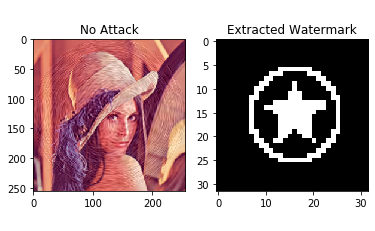

In [62]:
attackAndDisplay(IMG_WATERMARKED, 'No Attack')

Progress: [####################] 100.0%
BE  :  57.0
BER :  5.57%
Inverse Translation X=0 Y=0


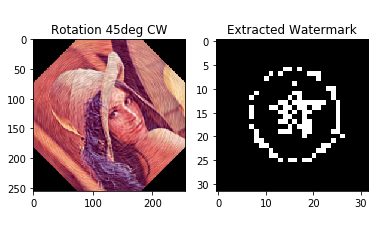

In [63]:
# Attack: Rotation 30 degree
ROTATION_ANGLE = 45
IMG_ROTATE = attackRotation(IMG_WATERMARKED, ROTATION_ANGLE)
attackAndDisplay(IMG_ROTATE, 'Rotation {}deg CW'.format(ROTATION_ANGLE), True)

Progress: [####################] 100.0%
BE  :  23.0
BER :  2.25%


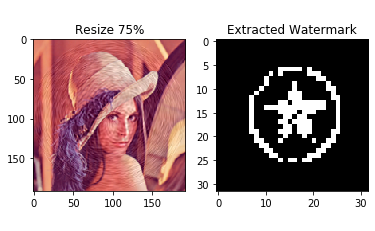

In [64]:
# Attack: Resize 75%
RESIZE_FACTOR = 0.75
IMG_RESIZE = attackResize(IMG_WATERMARKED, int(RESIZE_FACTOR * N))
attackAndDisplay(IMG_RESIZE, 'Resize ' + '{:.0%}'.format(RESIZE_FACTOR))

Progress: [####################] 100.0%
BE  :  52.0
BER :  5.08%
Inverse Translation X=-15 Y=13


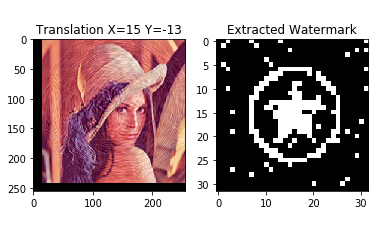

In [65]:
# Attack: Translation By Pixel

TRANSLATION_X_PIXEL = 15
TRANSLATION_Y_PIXEL = -13

IMG_TRANSLATE2 = attackTranslateByPixel(IMG_WATERMARKED, TRANSLATION_X_PIXEL, TRANSLATION_Y_PIXEL)
attackAndDisplay(IMG_TRANSLATE2, 'Translation X={} Y={}'.format(TRANSLATION_X_PIXEL, TRANSLATION_Y_PIXEL), True)

Progress: [####################] 100.0%
BE  :  95.0
BER :  9.28%
Inverse Translation X=-12 Y=12


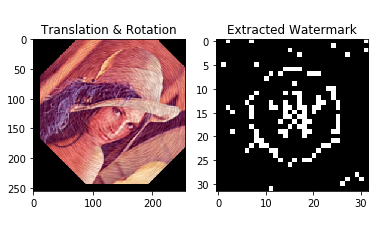

In [66]:
# Attack: Translation

TRANSLATION_X_PERCENTAGE = 0.05
TRANSLATION_Y_PERCENTAGE = -0.05

IMG_TRANSLATE = attackRotation(IMG_WATERMARKED, -45)
IMG_TRANSLATE = attackTranslate(IMG_TRANSLATE, TRANSLATION_X_PERCENTAGE, TRANSLATION_Y_PERCENTAGE)
attackAndDisplay(IMG_TRANSLATE, 'Translation & Rotation', True)

Progress: [####################] 100.0%
BE  :  21.0
BER :  2.05%


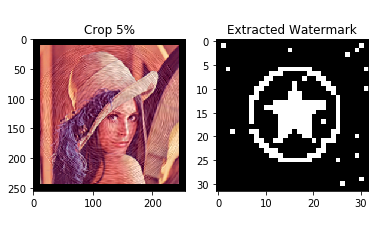

In [67]:
# Attack: FRAME 5%
CROP_PERCENTAGE = 0.05

IMG_CROP = attackCrop(IMG_WATERMARKED, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE)
attackAndDisplay(IMG_CROP, 'Crop ' + '{:.0%}'.format(CROP_PERCENTAGE))

Progress: [####################] 100.0%
BE  :  87.0
BER :  8.50%


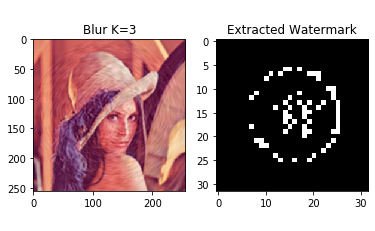

In [68]:
# Attack: BLUR 3x3
BLUR_KERNEL_SIZE = 3

IMG_BLUR = attackBlur(IMG_WATERMARKED, BLUR_KERNEL_SIZE)
attackAndDisplay(IMG_BLUR, 'Blur K={}'.format(BLUR_KERNEL_SIZE))

In [ ]:
# Attack: RANDOM NOISE 3%

NOISE_PERCENTAGE = 0.05
IMG_NOISE = attackRandomNoise(IMG_WATERMARKED, NOISE_PERCENTAGE)
attackAndDisplay(IMG_NOISE, 'Noise ' + '{:.0%}'.format(NOISE_PERCENTAGE))

Progress: [############--------] 62.3%


In [ ]:
# Attack: JPG Compression
COMPRESSION_QUALITY = 60
IMG_JPG = attackJPG(IMG_WATERMARKED, ROTATION_ANGLE)
attackAndDisplay(IMG_JPG, 'JPG Compression Q={}'.format(COMPRESSION_QUALITY), False)